# Data Mining for Security Applications: Final project



# Importing Libs


In [1]:
import os
import cv2
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np 
import pandas as pd

# Loading Images

In [2]:
train_dir = Path("./train/")

images = sorted(list(map(str, list(train_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print(f"Number of images found: {len(images)}")
print(f"Number of labels found: {len(labels)}")
print(f"Number of unique characters: {len(characters)}")
print(f"Characters present: {characters}")

Number of images found: 942
Number of labels found: 942
Number of unique characters: 19
Characters present: {'y', 'g', '5', '3', '7', '6', '2', 'n', 'm', 'p', 'x', 'f', '4', 'c', 'b', '8', 'd', 'e', 'w'}


In [3]:
test_dir = Path("./test/")

test_images = sorted(list(map(str, list(test_dir.glob("*.png")))))
test_labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in test_images]
test_characters = set(char for label in labels for char in label)

print(f"Number of images found: {len(test_images)}")
print(f"Number of labels found: {len(test_labels)}")
print(f"Number of unique characters: {len(test_characters)}")
print(f"Characters present: {test_characters}")

Number of images found: 98
Number of labels found: 98
Number of unique characters: 19
Characters present: {'y', 'g', '5', '3', '7', '6', '2', 'n', 'm', 'p', 'x', 'f', '4', 'c', 'b', '8', 'd', 'e', 'w'}


Both, the Training and the Test data only contain a total of 19 different characters, therefore I will check if those are identical:

In [4]:
print(characters.difference(test_characters))

set()


# Initial Look at the Captchas

Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)


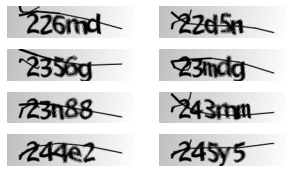

In [5]:
_,ax = plt.subplots(4,2, figsize=(5,3))

for i in range(8):
    img = cv2.imread(str(images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

In [6]:
test_labels
max_len = max([len(i) for i in test_labels])
min_len = min([len(i) for i in test_labels])
print("Maximum Length: ", max_len)
print("Maximum Length: ", min_len)

Maximum Length:  5
Maximum Length:  5


All Images seem to have the sampe shape and contain 5 letter Chaptchas that are crossed trough by a horizontal line.

Also there seems to be a small second line close to the first character of the captcha

# Extracting labelled characters

The long horizontal line will be removed by Erosion and dilation. First we will threshold the image, using adaptive thresolding , then we will dilate to remove that line. 

Its also clearly visible that each image contains 5 characters and the horizontal positions of all 5 characters are always same.

Every character's position in the image will be hardcoded and extraced with the corresponding label. Because of the fixed positions, this approach performs better than other methods (e.g. densitiy based clustering) 

We wil pad each character image to change it in required dimension.

Idea from 
https://www.kaggle.com/bharatbansal/ocr-with-opencv-92-9-accuracy-on-captcha-codes#Loading-images

In [7]:
kernel =np.ones((3,1),np.uint8)
borderType = cv2.BORDER_CONSTANT
def pad(src): 
    top = int(0.05 * src.shape[0])  #rows
    bottom = top
    left = int(0.15 * src.shape[1])  #cols
    right = left
    des=cv2.copyMakeBorder(src, top, bottom, left+1, right, borderType, None,255)
    return cv2.bitwise_not(des)

In [8]:
x_train=[]
y_train=[]
for image in images:
    im=cv2.imread(str(image),0)
    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
    erosion =cv2.dilate(threshold,kernel,iterations=2)
    s=str(image)
    for i in range(5):
        x_train.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
        y_train.append(s[-9+i])

Every character is now extracted and the correspondig solution is stored as a label

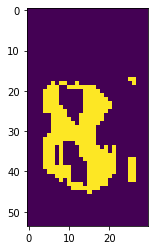

In [9]:
plt.imshow(x_train[102])

In [10]:
y_train[102]

'8'

In [11]:
type(x_train[45])

numpy.ndarray

In [12]:
len(x_train)

4710

In [13]:
x_train=np.array(x_train)
y_train=np.array(y_train)

We were working with a total of 942 images, that contained 5 letters each, therefore the total number of characters should be 4710, as seen above

In [14]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
ind=np.argsort(frequencies[:,-1])
frequencies=frequencies[ind]

In [15]:
print(frequencies)

[['e' '209']
 ['w' '211']
 ['y' '212']
 ['b' '212']
 ['p' '229']
 ['7' '232']
 ['d' '234']
 ['g' '236']
 ['3' '237']
 ['c' '238']
 ['m' '240']
 ['6' '241']
 ['2' '241']
 ['f' '242']
 ['x' '246']
 ['8' '246']
 ['4' '259']
 ['5' '263']
 ['n' '482']]


<BarContainer object of 19 artists>

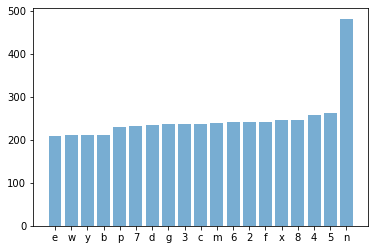

In [16]:
x_axis= frequencies[:,0]
y_axis= frequencies[:,1]
y_axis=y_axis.astype(int)
plt.bar(x_axis, y_axis, align='center', alpha=0.6)

The only big outlier seems to be the character "n" appearing 482 times

In [17]:
x_train=np.reshape(x_train,(-1,54,30,1))

In [18]:
y2_train = []
l=['2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y']
for j in y_train:
    i=l.index(j)
    a=[]
    for r in range(19):
        if(r==i):
            a.append(1)
        else:
            a.append(0)
    a=np.array(a)
    y2_train.append(a)
y2_train=np.array(y2_train)   

The above step was done in order simulate one hot encoding (0-18) for the given labels, as they formerly contained numbers and characters

# Preparing Test Data

In [19]:
x_test=[]
y_test=[]
for image in test_images:
    im=cv2.imread(str(image),0)
    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
    erosion =cv2.dilate(threshold,kernel,iterations=2)
    s=str(image)
    for i in range(5):
        x_test.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
        y_test.append(s[-9+i])
        
        

The created lists need to be converted into a numpy array for further usage

In [20]:
x_test=np.array(x_test)
y_test=np.array(y_test)

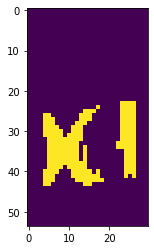

In [21]:
plt.imshow(x_test[21])

In [22]:
y_test[21]

'x'

The above was done in order to chack on a single sample if the indexing of the label seems to be correct

In [23]:
x_test=np.reshape(x_test,(-1,54,30,1))

All of the possible characters will be transformed with an encoding from 0 to 18:

In [24]:
y2_test = []
l=['2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y']
for j in y_test:
    i=l.index(j)
    a=[]
    for r in range(19):
        if(r==i):
            a.append(1)
        else:
            a.append(0)
    a=np.array(a)
    y2_test.append(a)
y2_test=np.array(y2_test)  

# Inital Ideas
The dimension of the arrays in the current form is 4.
Therefore 2 different solutions to this problem can be applied:
1. Reduce the dimension to 2 and use "classical" ML-Algos
2. Use CNNs, which typically perform well on image input

# Version 1: Reshape to 2D arrays

scikit-learn expects 2d num arrays for the training dataset for a fit function (ValueError: Found array with dim 4. Estimator expected <= 2.). 

The dataset in this case is a 4d array and needs to be reshaped into 2d.

In [25]:
x_train.shape

(4710, 54, 30, 1)

In [26]:
nsamples, nx, ny, nz = x_train.shape
d2_x_train = x_train.reshape((nsamples,nx*ny*nz))

nsamples, nx, ny, nz = x_test.shape
d2_x_test = x_test.reshape((nsamples,nx*ny*nz))

## PCA
By performing a PCA, I'll try to identify, if dimensionality of the dataset can be reduced

In [27]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(d2_x_train)

PCA()

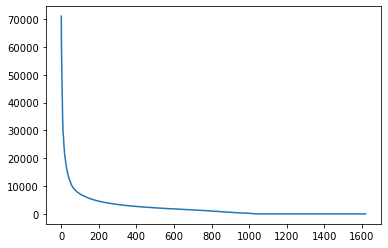

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(pca.singular_values_)

The values for all dimensions seem to be above 0, therefore the dimensions will not be reduced in this case.
Also the running time of the ML algorithms is adequate, therefore there is no need to risk even a small amount of information loss

## 1.1 Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=3000,max_depth=None,n_jobs=-1)
rf_model = rf.fit(d2_x_train,y2_train)

In [30]:
from sklearn.metrics import classification_report
predictrf = rf_model.predict(d2_x_test)
print ("Random Forest:\n"+classification_report(y2_test, predictrf))

Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        24
           1       0.95      0.70      0.81        30
           2       1.00      0.88      0.94        25
           3       1.00      0.83      0.91        18
           4       1.00      0.78      0.88        18
           5       1.00      0.88      0.94        26
           6       1.00      0.67      0.80        18
           7       1.00      0.82      0.90        28
           8       1.00      0.83      0.91        24
           9       0.88      0.88      0.88        25
          10       1.00      0.77      0.87        26
          11       0.96      0.79      0.87        29
          12       1.00      0.89      0.94        35
          13       1.00      0.89      0.94        35
          14       0.97      0.74      0.84        43
          15       0.96      1.00      0.98        24
          16       1.00      0.67      0.80        24
          17

/home/kromy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
from sklearn.metrics import f1_score
f1_score(y2_test, predictrf, average='weighted', labels=np.unique(predictrf))

0.8527583527583528

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

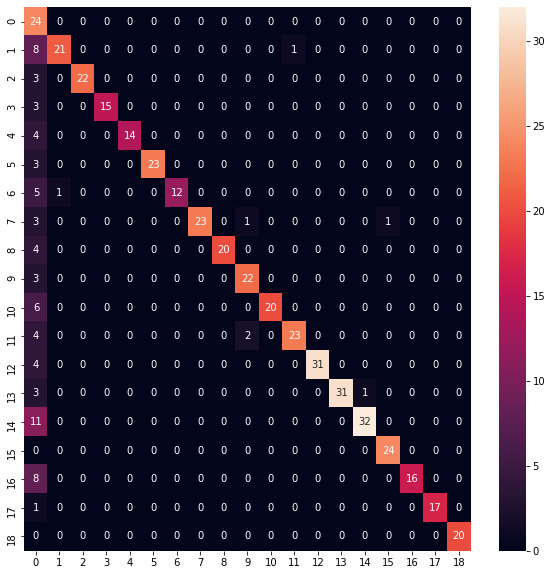

In [33]:
holder1 = np.argmax(y2_test,axis = 1)
holder2 = np.argmax(predictrf,axis = 1)
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(confusion_matrix(holder1,holder2), annot=True,ax=ax)

other characters get often identified as category 0(=2)

## 1.2 KNN Classifier

In [34]:
from sklearn.neighbors import KNeighborsClassifier
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(d2_x_train,y2_train); 

In [35]:
predictkn = KNN_Classifier.predict(d2_x_test)
print ("KNN:\n"+classification_report(y2_test, predictkn))

KNN:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        24
           1       0.82      0.77      0.79        30
           2       0.92      0.92      0.92        25
           3       0.95      1.00      0.97        18
           4       1.00      0.89      0.94        18
           5       1.00      0.88      0.94        26
           6       1.00      0.50      0.67        18
           7       0.96      0.82      0.88        28
           8       0.95      0.83      0.89        24
           9       0.84      0.84      0.84        25
          10       1.00      0.92      0.96        26
          11       0.96      0.90      0.93        29
          12       1.00      0.91      0.96        35
          13       0.87      0.77      0.82        35
          14       0.79      0.88      0.84        43
          15       0.96      1.00      0.98        24
          16       0.92      1.00      0.96        24
          17       1.0

/home/kromy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
from sklearn.metrics import f1_score
f1_score(y2_test, predictkn, average='weighted', labels=np.unique(predictkn))

0.8566886769381266

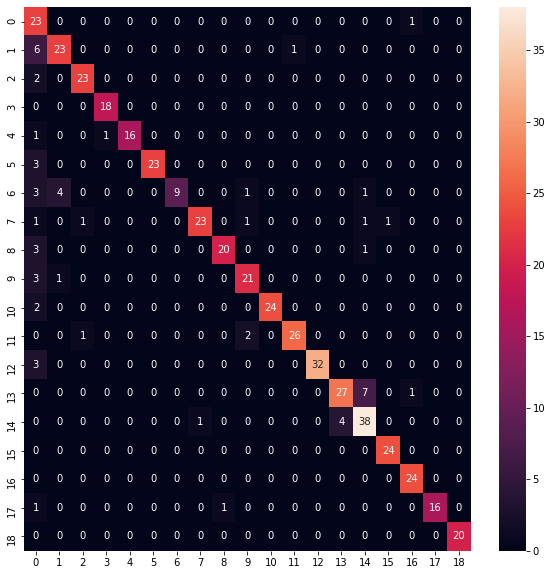

In [37]:
holder1 = np.argmax(y2_test,axis = 1)
holder2 = np.argmax(predictkn,axis = 1)
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(confusion_matrix(holder1,holder2), annot=True,ax=ax)

Interesting about this confusion matrix is the fact, that not only other characters get often identified as category 0(=2), but also the categories 13(=m) and 14(=n) are often mixed up

## 1.3 MLP Classifier

In [38]:
from sklearn.neural_network import MLPClassifier

In [39]:
clf= MLPClassifier(hidden_layer_sizes=([512]*5),activation="relu",random_state=1).fit(d2_x_train,y2_train)

In [40]:
predictMLP = clf.predict(d2_x_test)
print ("KNN:\n"+classification_report(y2_test, predictMLP))

KNN:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        24
           1       0.91      0.70      0.79        30
           2       0.82      0.92      0.87        25
           3       1.00      0.83      0.91        18
           4       1.00      0.83      0.91        18
           5       0.96      0.96      0.96        26
           6       0.76      0.72      0.74        18
           7       0.93      0.89      0.91        28
           8       0.95      0.83      0.89        24
           9       0.89      0.96      0.92        25
          10       0.88      0.81      0.84        26
          11       0.90      0.93      0.92        29
          12       1.00      0.86      0.92        35
          13       0.84      0.91      0.88        35
          14       0.97      0.77      0.86        43
          15       0.92      1.00      0.96        24
          16       0.88      0.88      0.88        24
          17       0.8

/home/kromy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
from sklearn.metrics import f1_score
f1_score(y2_test, predictMLP, average='weighted', labels=np.unique(predictMLP))

0.8550663871418588

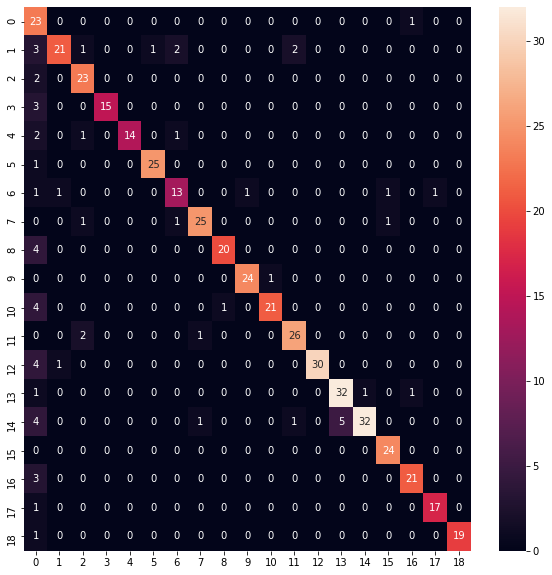

In [42]:
holder1 = np.argmax(y2_test,axis = 1)
holder2 = np.argmax(predictMLP,axis = 1)
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(confusion_matrix(holder1,holder2), annot=True,ax=ax)

other characters get often identified as category 0(=2)

# Version 2: Keras Sequential

In [43]:
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau



In [44]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (54,30,1)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(19, activation = "softmax"))

In [80]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 30, 16)        416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 30, 16)        6416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 15, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 27, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 15, 32)        12832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 15, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 7, 32)         0

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

The model needs to know what input shape it should expect. For this reason, the first layer in a Sequential model needs to receive information about its input shape

In [45]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [46]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False, 
        zca_whitening=False, 
        rotation_range=5, 
        zoom_range = False, 
        width_shift_range=0.1,  #hift images horizontally 
        height_shift_range=0.1,  #shift images vertically
        horizontal_flip=False,  
        vertical_flip=False)  

### Image Data Generator
The image augmentation technique is done in order to expand the size of the dataset. It creates new transformed images from the original dataset.

The main benefit of using the Keras ImageDataGenerator class is that it is designed to provide real-time data augmentation, meaning it is generating augmented images on the fly while the model is still in the training stage.

In [47]:
datagen.fit(x_train)

In [48]:
batch_size=86

In [49]:
history = model.fit(datagen.flow(x_train,y2_train, batch_size=batch_size),
                              epochs =  40, validation_data = (x_test,y2_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/40
54/54 [==============================] - 18s 320ms/step - loss: 4.4984 - accuracy: 0.0694 - val_loss: 2.4776 - val_accuracy: 0.2449
Epoch 2/40
54/54 [==============================] - 16s 299ms/step - loss: 2.5291 - accuracy: 0.1907 - val_loss: 1.3457 - val_accuracy: 0.6102
Epoch 3/40
54/54 [==============================] - 16s 305ms/step - loss: 1.8066 - accuracy: 0.4299 - val_loss: 0.8185 - val_accuracy: 0.7673
Epoch 4/40
54/54 [==============================] - 16s 302ms/step - loss: 1.2523 - accuracy: 0.6144 - val_loss: 0.6247 - val_accuracy: 0.8041
Epoch 5/40
54/54 [==============================] - 17s 316ms/step - loss: 0.8787 - accuracy: 0.7324 - val_loss: 0.5043 - val_accuracy: 0.8224
Epoch 6/40
54/54 [==============================] - 18s 340ms/step - loss: 0.7612 - accuracy: 0.7692 - val_loss: 0.5177 - val_accuracy: 0.8245
Epoch 7/40
54/54 [==============================] - 18s 327ms/step - loss: 0.6137 - accuracy: 0.8150 - val_loss: 0.5012 - val_accuracy: 0.8265

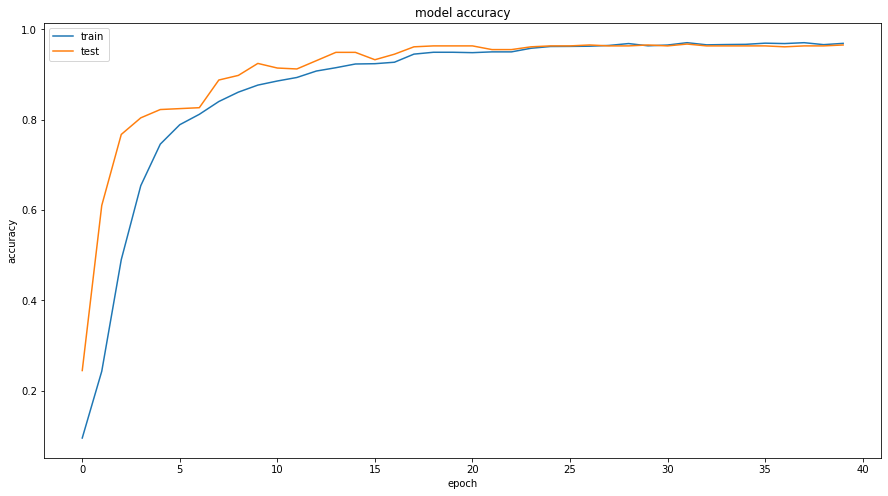

In [50]:
plt.figure(figsize=(15,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
print("The final accuracy is: ",history.history['accuracy'][-1])


The final accuracy is:  0.9688581228256226


In [52]:
Keras_pred = model.predict(x_test)


In [53]:
holder1 = np.argmax(y2_test,axis = 1)
holder2 = np.argmax(Keras_pred,axis = 1)
print ("KNN:\n"+classification_report(holder1, holder2))

KNN:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       0.96      0.90      0.93        30
           2       1.00      1.00      1.00        25
           3       0.90      1.00      0.95        18
           4       0.94      0.94      0.94        18
           5       1.00      1.00      1.00        26
           6       1.00      0.89      0.94        18
           7       0.93      1.00      0.97        28
           8       0.96      0.96      0.96        24
           9       0.96      0.96      0.96        25
          10       0.96      1.00      0.98        26
          11       0.97      1.00      0.98        29
          12       0.97      0.97      0.97        35
          13       0.89      0.97      0.93        35
          14       0.97      0.86      0.91        43
          15       1.00      1.00      1.00        24
          16       0.96      1.00      0.98        24
          17       1.0

In [54]:
f1_score(holder1, holder2, average='weighted')

0.9650275305235141

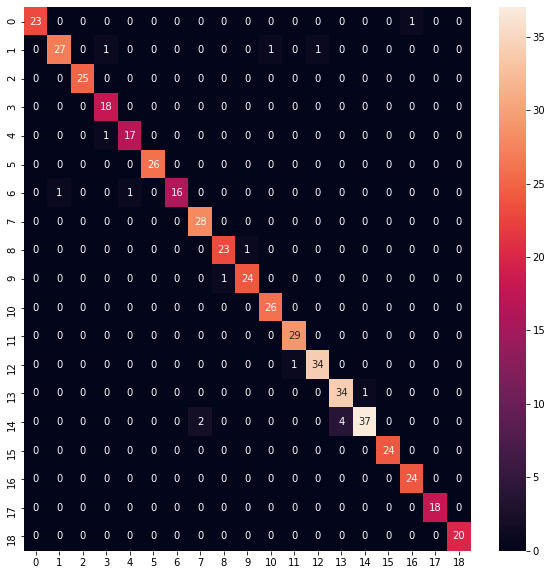

In [55]:

fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(confusion_matrix(holder1,holder2), annot=True,ax=ax)

# Conclusion
The Sequential Keras approach has no significant amount of misclassicifations for certain characters. All other methods tested, misclassify a lot of characters as category 0(encoded), which translates to the number 2.

Interseting Side Note: The KNN Classifier  is the only one that has problems mixing up the classification of the characters m and n

## F1-Scores
* Random Forest: 0.85
* KNN: 0.86
* MLP: 0.85
* Sequential Keras: 0.97

Because of the significantly superior results, I will use the earlier created Keras Model for the final classification pipeline

# Predicting a complete Captcha
The goal of the following pipeline is, to not only identify a single preprocessed character, but to input a complete image and in return recieve a solution in the form of a 5 character long string, that solves the captcha

In [56]:
test_dir = Path("./test/")

In [57]:
image = list(test_dir.glob("*.png"))[9]

The image used as an example is taken from index "9" in the list

In [58]:
def solver(image):
    im=cv2.imread(str(image),0)

    
    
    
    x_ex=[]
    y_ex=[]

    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
    erosion =cv2.dilate(threshold,kernel,iterations=2)
    s=str(image)
    for i in range(5):
        x_ex.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
        y_ex.append(s[-9+i])
        
    x_ex=np.array(x_ex)
    y_ex=np.array(y_ex)
    
    x_ex=np.reshape(x_ex,(-1,54,30,1))
    
    y2_ex = []
    l=['2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y']
    for j in y_ex:
        i=l.index(j)
        a=[]
        for r in range(19):
            if(r==i):
                a.append(1)
            else:
                a.append(0)
        a=np.array(a)
        y2_ex.append(a)
    y2_ex=np.array(y2_ex)  
    
    Y_pred = model.predict(x_ex)
    
    
    Y_pred_classes = np.argmax(Y_pred,axis=1)
    solution=""
    
    for j in Y_pred_classes:
        solution+=l[j]
    print(solution)

In [59]:
solver(image)

7g3nf


The function "solver" gets called using an image as input and print the solution of the captcha.


In this case it is 7g3nf
 
  



### The following steps are only done in order to visualize what is happening during the solution process:

In [60]:
 im=cv2.imread(str(image),0)

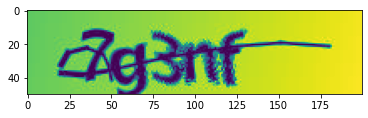

In [61]:


c = plt.imshow(im) 
plt.show() 

In [62]:
x_ex=[]
y_ex=[]

threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
erosion =cv2.dilate(threshold,kernel,iterations=2)
s=str(image)
for i in range(5):
    x_ex.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
    y_ex.append(s[-9+i])

'7'

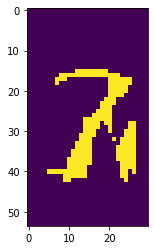

In [63]:
plt.imshow(x_ex[0])
y_ex[0]

'g'

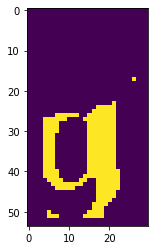

In [64]:
plt.imshow(x_ex[1])
y_ex[1]

'3'

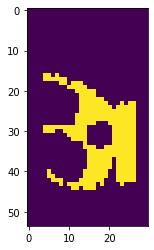

In [65]:
plt.imshow(x_ex[2])
y_ex[2]

'n'

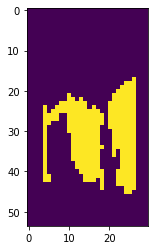

In [66]:
plt.imshow(x_ex[3])
y_ex[3]

'f'

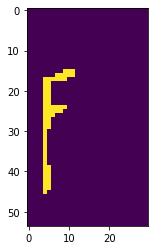

In [67]:
plt.imshow(x_ex[4])
y_ex[4]

In [68]:
x_ex=np.array(x_ex)
y_ex=np.array(y_ex)

In [69]:
x_ex=np.reshape(x_ex,(-1,54,30,1))

In [70]:
y2_ex = []
l=['2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y']
for j in y_ex:
    i=l.index(j)
    a=[]
    for r in range(19):
        if(r==i):
            a.append(1)
        else:
            a.append(0)
    a=np.array(a)
    y2_ex.append(a)
y2_ex=np.array(y2_ex)  

In [71]:
Y_pred = model.predict(x_ex)


In [72]:
Y_pred.shape

(5, 19)

In [73]:
Y_pred_classes = np.argmax(Y_pred,axis=1)

In [74]:
Y_pred_classes

array([ 5, 12,  1, 14, 11])

In [75]:
Y_true_classes = np.argmax(y2_ex,axis = 1)


In [76]:
Y_true_classes

array([ 5, 12,  1, 14, 11])

In [77]:
for j in Y_pred_classes:
    print(l[j])

7
g
3
n
f
